In [1]:
import sys
from pathlib import Path
import importlib.util
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import scipy.stats as stats
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from pandas.plotting import table

# notebooks/.. = project_root
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


package_dir = project_root / "scdb_code_map"
init_file = package_dir / "__init__.py"
init_file.touch(exist_ok=True)  # creates empty __init__.py if missing


spec = importlib.util.find_spec("scdb_code_map")
if spec is None:
    raise ImportError(f"Cannot find 'scdb_code_map' in {project_root}")


from scdb_code_map import LAW_SUPP_MAP, LAW_TYPE_MAP, DECISION_DIRECTION_MAP, AUTHORITY_DECISION_MAP, ISSUE_AREA_MAP, CASE_DISPOSITION_MAP

In [2]:
conn = sqlite3.connect("../data/legal_sc.db")
c_issues = pd.read_sql("SELECT * FROM c_issues", conn)

In [7]:
# Analyzes the most frequently cited laws or amendments.

def analyze_citations(df, max_len=40):

    # Map lawSupp and lawType to words
    df["lawSuppText"] = df["lawSupp"].map(LAW_SUPP_MAP).fillna("Unknown")
    df["lawTypeText"] = df["lawType"].map(LAW_TYPE_MAP).fillna("Unknown")

    # Drop rows where either lawSuppText or lawTypeText columns ended up as "Unknown"
    # use the | symbol for "OR" logic
    df_clean = df[
        (df["lawSuppText"] != "Unknown") & 
        (df["lawTypeText"] != "Unknown")
    ]

    # keeps the LawSupp and lawType and its Category together
    # count the number of occurrences for each unique pair
    law_counts = df_clean.groupby(['lawSuppText', 'lawTypeText']).size().sort_values(ascending=False)

    # print the result
    print("--- Top 10 Most Cited Laws (with Category) ---")
    print(law_counts.head(10))

    # Convert to DataFrame and name the count column
    top_cited = law_counts.head(10).to_frame(name='# Cited')

    # Move lawSuppText and lawTypeText from the index into actual columns
    top_cited = top_cited.reset_index()


    # Truncate long law names
    top_cited['lawSuppText'] = top_cited['lawSuppText'].apply(
        lambda x: x if len(x) <= max_len else x[:max_len] + "…"
    )
    
    # Rename the columns
    top_cited = top_cited.rename(columns={
        'lawSuppText': 'Law Cited',
        'lawTypeText': 'Law Type'
    })

    # try to add a title and style the table
    styled_table = (
        top_cited.style
        .hide(axis='index')
        .set_caption("Most Cited Laws in Supreme Court Cases")
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('padding-bottom', '10px')
            ]}
        ])
        .set_properties(**{
            'text-align': 'left',
            'padding': '10px'
        })
    )

    # save the table as a jpeg
    dfi.export(
        styled_table, 
        '../results/tbl_mostCitedLaw.jpg', 
        table_conversion='matplotlib'
    )

    return law_counts


results = analyze_citations(c_issues)


--- Top 10 Most Cited Laws (with Category) ---
lawSuppText                                                                                                                               lawTypeText                    
Infrequently litigated statutes                                                                                                           Infrequently litigated statutes    2550
Fourteenth Amendment (due process)                                                                                                        Constitutional Amendment            608
First Amendment (speech, press, and assembly)                                                                                             Constitutional Amendment            529
Fourteenth Amendment (equal protection)                                                                                                   Constitutional Amendment            489
Internal Revenue Code and pre-IRC revenue acts                         

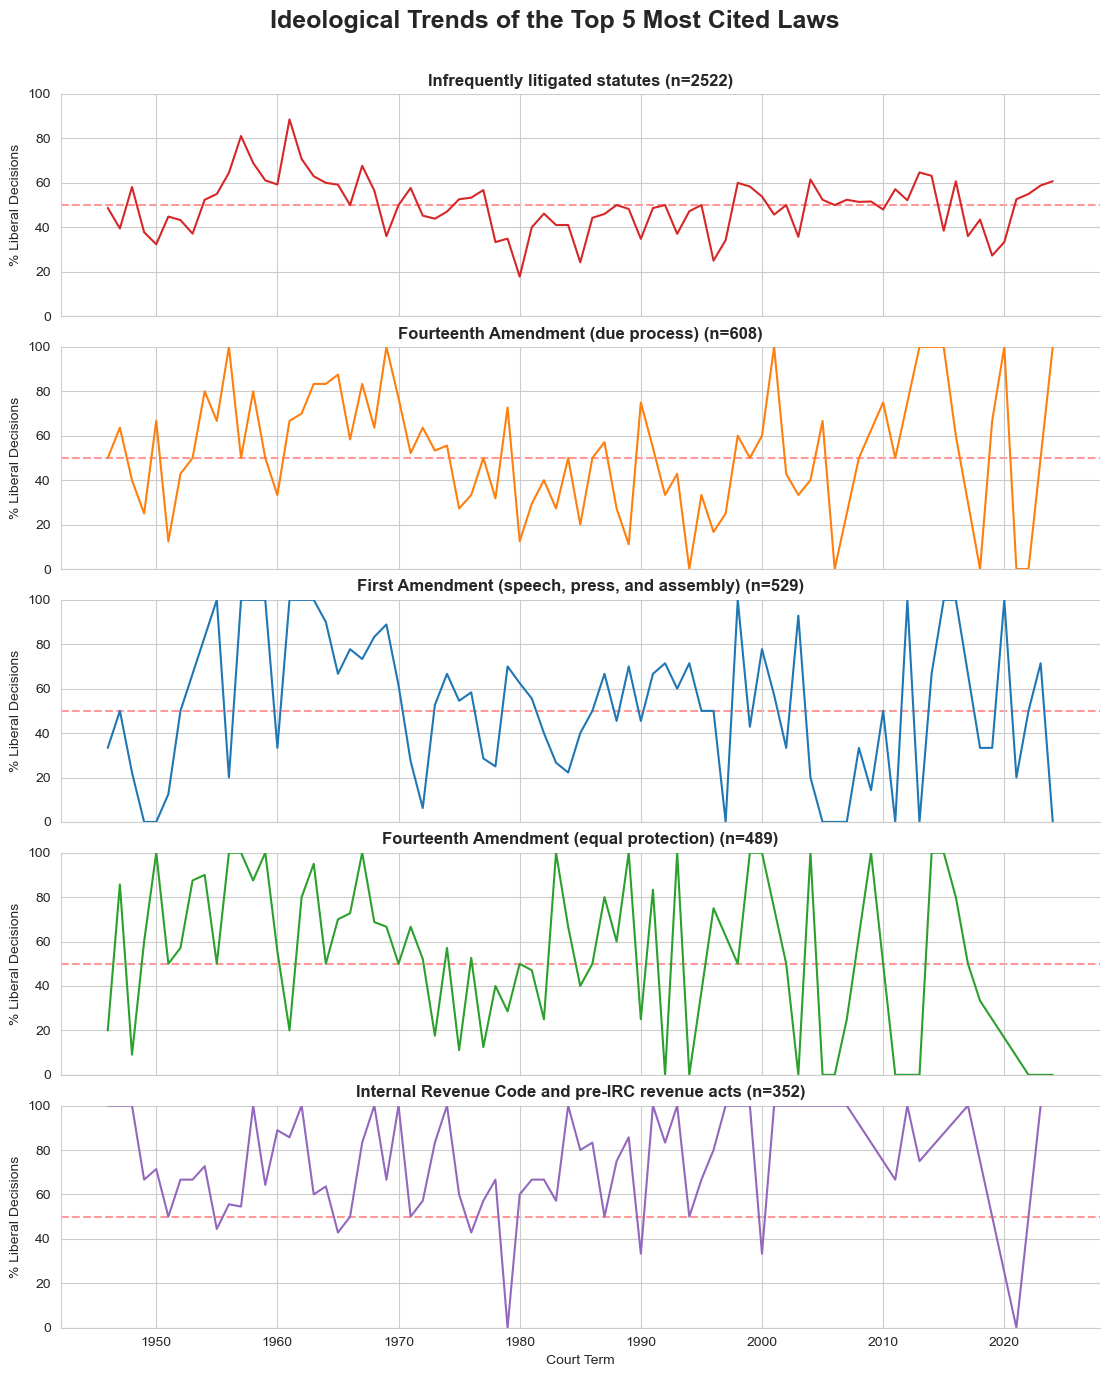

In [4]:
# For the most cited laws, check whether the decision become more liberal or conservative over time

def plot_ideological_trends_vertical(df):
    # Map lawSupp to readable names and clean data
    df["lawSuppText"] = df["lawSupp"].map(LAW_SUPP_MAP).fillna("Unknown")
    
    # Filter for valid decision directions and drop Unknowns laws
    df_clean = df[
        (df["lawSuppText"] != "Unknown") & 
        (df["decisionDirection"].isin([1, 2]))
    ].copy()
    
    # Identify top n laws and sort from high to low
    n = 5
    counts = df_clean['lawSuppText'].value_counts().head(n)
    top_laws_ordered = counts.index.tolist() # a list of n most frequent lawSuppText values, ordered high to low
    
    # uses list comprehension and string formatting to create readable labels that include both the law name and its count
    # create labels that look like Section 123 (n=42)
    order_with_counts = [f"{law} (n={counts[law]})" for law in top_laws_ordered] # this is a list used for plotting later
    
    # Add the display label to the dataframe
    name_map = {law: f"{law} (n={counts[law]})" for law in top_laws_ordered} # this is a dictionary
    df_top = df_clean[df_clean['lawSuppText'].isin(top_laws_ordered)].copy()
    df_top['law_label'] = df_top['lawSuppText'].map(name_map)
    
    # Calculate Liberalism Score per Term per Law, 1 = conservative, 2 = liberal
    # assign 1 if True ('decisionDirection'] == 2), 0 if False
    df_top['is_liberal'] = (df_top['decisionDirection'] == 2).astype(int)
    trend_data = (
        df_top.groupby(['term', 'law_label'])['is_liberal'] # for a given year and law cited, give faction of liberal decision
        .mean()
        .reset_index()
    )
    trend_data['is_liberal'] *= 100 
    
    # Visualization using vertical panels where the year/term on x-axis is aligned for each law
    sns.set_style("whitegrid")
    
    g = sns.relplot(
        data=trend_data,
        x='term',
        y='is_liberal',
        row='law_label',
        row_order=order_with_counts, 
        hue='law_label',
        kind='line',
        height=2.8,         # Slightly taller rows
        aspect=4.0,         # Wide enough for the timeline
        facet_kws={'sharey': True, 'sharex': True},
        legend=False
    )

    # Adding the netrality line (50%) to every panel
    g.map(plt.axhline, y=50, color='red', linestyle='--', alpha=0.4, zorder=0)

    # formatting titles and labels
    g.set_titles(row_template="{row_name}", size=12, weight='bold')
    g.set_axis_labels("Court Term", "% Liberal Decisions")
    g.set(ylim=(0, 100)) 

    # Fix title to make sure there is enough room for title to not overlap on top of each other
    
    plt.subplots_adjust(top=0.92) 
    g.figure.suptitle(
        'Ideological Trends of the Top 5 Most Cited Laws', 
        fontsize=18, 
        fontweight='bold',
        y=0.98  
    )
    # -----------------------------

    # save
    # bbox_inches='tight' is crucial for tall figures
    plt.savefig('../results/MostCitedLaw_decision_trends.jpg', bbox_inches='tight', dpi=300)
    plt.show()

plot_ideological_trends_vertical(c_issues)

In [3]:
# Look at whether the Court lean more conservative or liberal based on authorityDecision1
# authorityDecision1 tells whether the authority is based on judicial review of state/local laws versus federal statutes etc

# Map authority codes to text
c_issues["authorityDecision1Text"] = c_issues["authorityDecision1"].map(AUTHORITY_DECISION_MAP)

# Map decision direction
c_issues["decisionDirectionText"] = c_issues["decisionDirection"].map(
    DECISION_DIRECTION_MAP
)

# Drop unclear outcomes (not conservative or liberal)
c_issues_clean = c_issues[c_issues["decisionDirectionText"] != "Unclear"].copy()

# reset to boolean coding Conservative = 1, Liberal = 0
c_issues_clean["conservative"] = (c_issues_clean["decisionDirectionText"] == "Conservative").astype(int)

# n_cases counts the number of rows in each group, essentially number of cases for that authority type
# Since conservative is coded 1 for Conservative, 0 for Liberal, the mean = proportion of Conservative cases in that group
summary = (
    c_issues_clean.groupby("authorityDecision1Text")
      .agg(
          n_cases=("conservative", "size"),
          pct_conservative=("conservative", "mean")
      )
)

print(summary)

# Interpretation
# since all results are near 0.5, the type of authority (authorityDecision1) does not strongly predict 
# whether the Court rules Conservative or Liberal

                                                    n_cases  pct_conservative
authorityDecision1Text                                                       
Diversity jurisdiction                                   22          0.500000
Federal common law                                      894          0.493289
Interpretation of administrative regulation or ...      684          0.502924
Judicial review (national level)                       1855          0.549326
Judicial review (state level)                          2950          0.467458
Statutory construction                                 5762          0.481777
Supreme Court supervision of lower federal or s...     1460          0.506849


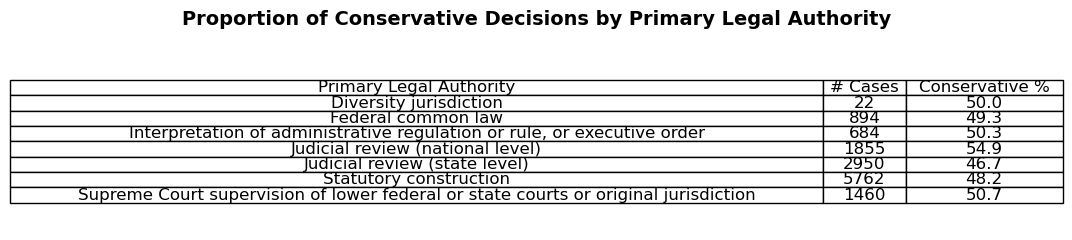

In [4]:
# plot ans save the table above as jpg
# not using dfi.export, build the table manually with matplotlib 

# Reset index and rename column
summary_reset = summary.reset_index()
summary_reset = summary_reset.rename(columns={
    "authorityDecision1Text": "Primary Legal Authority",
    "n_cases": "# Cases",
    "pct_conservative": "Conservative %"
})

# format pct_conservative as percentage with 1 decimal
summary_reset["Conservative %"] = (summary_reset["Conservative %"] * 100).round(1)

# Create figure
fig, ax = plt.subplots(figsize=(12, 2.5))  # adjust size as needed
ax.axis('off')

# Add a title
plt.title("Proportion of Conservative Decisions by Primary Legal Authority", fontsize=14, fontweight='bold', pad=20)

# Create table
tbl = ax.table(
    cellText=summary_reset.values,
    colLabels=summary_reset.columns,
    cellLoc='center',
    loc='center'
)

# Adjust font size and column width
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(summary_reset.columns))))

# Save as JPEG
plt.tight_layout()
plt.savefig("../results/tbl_authority_decisions_trend.jpg", dpi=300, bbox_inches='tight')
plt.show() 
plt.close()

In [7]:
# check if the Court is more ideologically divided (5/4 or 6/3 split) when interpreting Statutes compared to the Constitution
# interested in the lawType column where 
# 1 = Constitution, 2 = Constitutional Amendment, 3 = Federal Statute, 6 = Infrequently litigated statutes
# will compare court behavior for group {1, 2} against {3, 6}

# Also need the minVotes column
# First we compare "Unanimous vs. Any Dissent" as the starting point (minVotes = 0 vs. minVotes > 0)
# Then we look at  "Unanimous vs. High Conflict" (minVotes = 0 vs. minVotes = 4 or 3)

def analyse_division_by_lawType(df):
    # Map lawType codes to their text descriptions
    df['lawTypeText'] = df['lawType'].map(LAW_TYPE_MAP)

    # Assign the Research Groups
    def assign_law_group(desc):
        if desc in ['Constitution', 'Constitutional Amendment']:
            return 'Constitution'
        elif desc in ['Federal Statute', 'Infrequently litigated statutes']:
            return 'Federal Statute'
        return None # Filters out State Laws, Court Rules, and 'Other'

    df['law_group'] = df['lawTypeText'].apply(assign_law_group)

    # Create the Analysis Subset (Remove cases with no minVotes or no group)
    analysis_df = df.dropna(subset=['law_group', 'minVotes']).copy()

    # Define Division Metrics
    # Divided = At least one dissent
    analysis_df['is_divided'] = analysis_df['minVotes'] > 0
    # Deeply Split = The "Battleground" metric (>= 3 dissents)
    analysis_df['is_deeply_split'] = analysis_df['minVotes'] >= 3

    # Calculate results
    summary = analysis_df.groupby('law_group').agg(
        case_count=('caseId', 'nunique'),
        pct_divided=('is_divided', lambda x: x.mean() * 100),
        pct_deeply_split=('is_deeply_split', lambda x: x.mean() * 100)
    ).round(2)

    return summary


results = analyse_division_by_lawType(c_issues)
print(results)


# Interpretation
# the Court is more likely to be unanimous in cases involving statutory interpretation than in cases involving the Constitution
# Note: If the Court interprets a statute in a way Congress dislikes, Congress can simply pass a new law to "fix" it
# Note: If the Court makes a Constitutional ruling, it is nearly impossible to change except by a future Court or an Amendment


                 case_count  pct_divided  pct_deeply_split
law_group                                                 
Constitution           3295        71.54             44.16
Federal Statute        4863        60.57             32.23


In [12]:
# Repeat the analysis above, but for separate issueArea
# the goal is to see if the "Statutory vs. Constitutional" gap exists across all topics
# or if it's driven primarily by certain areas like Civil Rights or Economics

def analyse_division_by_lawType_issueArea(df):
    # Map law types and issue areas to words
    df['lawTypeText'] = df['lawType'].map(LAW_TYPE_MAP)
    df['issueAreaText'] = df['issueArea'].map(ISSUE_AREA_MAP)
    
    # Assign comparison groups
    def assign_law_group(name):
        if name in ['Constitution', 'Constitutional Amendment']:
            return 'Constitution'
        elif name in ['Federal Statute', 'Infrequently litigated statutes']:
            return 'Federal Statute'
        return None

    df['law_group'] = df['lawTypeText'].apply(assign_law_group)
    
    # Filter for valid data only
    # need both a law_group and an issue_area_name to make this work
    analysis_df = df.dropna(subset=['law_group', 'issueAreaText', 'minVotes']).copy()

    # Define division metric
    # High Conflict = 3 or more dissents (the "Battleground" cases)
    analysis_df['is_high_conflict'] = analysis_df['minVotes'] >= 3

    # Group by both Issue Area and Law Group
    pivot_results = analysis_df.groupby(['issueAreaText', 'law_group']).agg(
        case_count=('caseId', 'nunique'),
        pct_high_conflict=('is_high_conflict', lambda x: x.mean() * 100)
    ).round(2)

    # Unstack to make it easy to compare side-by-side
    comparison_table = pivot_results['pct_high_conflict'].unstack()
    
    # Add case counts separately if you want to see sample sizes
    counts_table = pivot_results['case_count'].unstack()

    return comparison_table, counts_table


comparison, counts = analyse_division_by_lawType_issueArea(c_issues)
print("Percentage of High-Conflict (Close) Decisions:")
print(comparison)

Percentage of High-Conflict (Close) Decisions:
law_group             Constitution  Federal Statute
issueAreaText                                      
Attorneys                    48.28            38.46
Civil Rights                 46.50            37.59
Criminal Procedure           48.30            42.44
Due Process                  38.50            15.07
Economic Activity            28.83            29.50
Federal Taxation              5.88            24.18
Federalism                   46.67            27.56
First Amendment              50.97            49.60
Interstate Relations         26.67            40.00
Judicial Power               33.07            24.09
Miscellaneous                32.56            22.58
Privacy                      63.10            36.00
Private Law                   0.00            33.33
Unions                       29.63            37.39


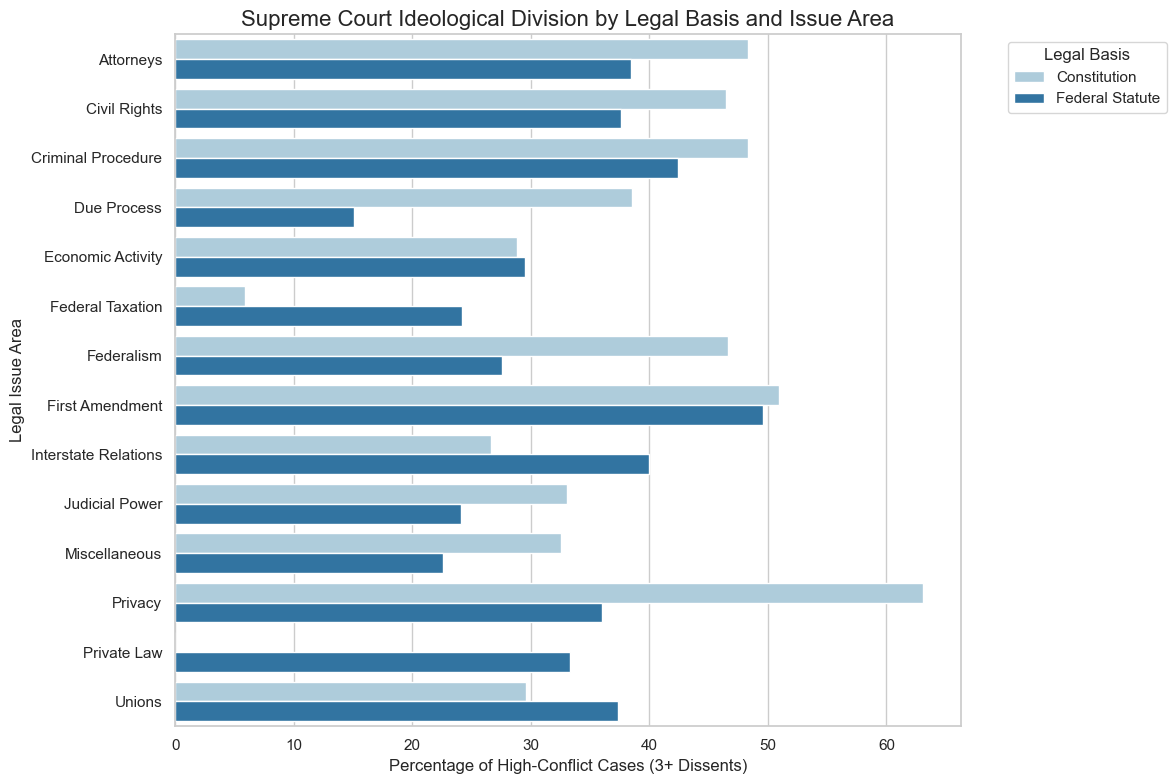

Plotting complete. File saved as 'scdb_plot.jpg'.


In [25]:
# plot the results above

# Transform the pivot table into "long-form" for Seaborn
# converts the index and columns into plottable variables
plot_data = comparison.stack().reset_index()

# Rename columns for clarity in the plot
# 'level_0' and 'level_1' are defaults from stacking; we give them names
plot_data.columns = ['Issue Area', 'Legal Basis', 'Pct High Conflict']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create the plot
plot = sns.barplot(
    data=plot_data,
    y='Issue Area',
    x='Pct High Conflict',
    hue='Legal Basis',
    palette='Paired'
)

# Formatting
plt.title('Supreme Court Ideological Division by Legal Basis and Issue Area', fontsize=16)
plt.xlabel('Percentage of High-Conflict Cases (3+ Dissents)', fontsize=12)
plt.ylabel('Legal Issue Area', fontsize=12)
plt.legend(title='Legal Basis', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout to prevent clipping of labels
plt.tight_layout()

# Save and Show
plt.savefig('../results/division_by_lawType_IssueArea.jpg', format='jpg', dpi=300)
plt.show()

print("Plotting complete. File saved as 'scdb_plot.jpg'.")

# Interpretation
# Most issue area shows the same trend where the court is much more divided when the legal bais = Consititution
# The most significant exceptions are Federal Taxation and Interstate Relations, and to a lesser extent Unions

In [5]:
# look into laws that are most likely to have their precedent altered
# use precedentAlteration column
# 0 = no determinable alteration of precedent, 1 = precedent altered


# prep the dataframe
c_issues_clean = c_issues.dropna(subset=["lawSupp", "precedentAlteration"])
c_issues_clean = c_issues_clean[c_issues_clean["precedentAlteration"].isin([0, 1])]
c_issues_clean["lawSuppText"] = c_issues_clean["lawSupp"].map(LAW_SUPP_MAP)
c_issues_clean["lawSuppText"] = c_issues_clean["lawSuppText"].fillna("Unknown")


# group by lawType and lawSuppText
law_summary = (
    c_issues_clean.groupby(["lawType", "lawSuppText"])
      .agg(
          total_cases=("lawSuppText", "count"),
          altered_cases=("precedentAlteration", "sum")
      )
      .reset_index()
)


law_summary["alteration_rate"] = (
    law_summary["altered_cases"] / law_summary["total_cases"]
)


# Filter out rarely cited laws
MIN_CASES = 10
law_summary = law_summary[law_summary["total_cases"] >= MIN_CASES]


# Rank laws by most likely to have precedent altered
law_summary = law_summary.sort_values(
    by="alteration_rate",
    ascending=False
)

# lawSuppText can be very long and wordy, only show the first n characters
law_summary["law_cited"] = (
    law_summary["lawSuppText"]
    .str.slice(0, 60)
    .str.rstrip()
)

# print result
print("Top 10 most unstable laws:")
print(
    law_summary[
        ["law_cited", "total_cases", "alteration_rate"]
    ].head(10)
     .to_string(index=False)
)

# doesn't make much sense to print the most stable or least likely to have precedent altered laws 
# as there are many with 0 alter rate

Top 10 most unstable laws:
                                                   law_cited  total_cases  alteration_rate
   Article I, Section 10, Paragraph 2 (export-import clause)           17         0.176471
                                      Twenty-First Amendment           25         0.160000
                                                    Estoppel           33         0.151515
                    Sixth Amendment (right to trial by jury)           64         0.140625
        Article IV, Section 1 (full faith and credit clause)           41         0.121951
           Article III, Section 2 (extent of judicial power)           17         0.117647
                                          Eleventh Amendment           56         0.107143
Article I, Section 8, Paragraph 3 (interstate commerce claus          221         0.095023
        Article I, Section 10, Paragraph 1 (contract clause)           23         0.086957
                                              Harmless Error   

In [6]:
# save the above table as jpeg

top10 = law_summary[
    ["law_cited", "total_cases", "alteration_rate"]
].head(10)

# round alteration_rate
top10["alteration_rate"] = top10["alteration_rate"].round(2)


fig, ax = plt.subplots(figsize=(10, 4)) 
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=top10.values,
    colLabels=top10.columns,
    cellLoc='left',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(top10.columns))))

# Add title
plt.title("Top 10 Most Unstable Laws by Precedent Alteration", fontsize=14, pad=5)


# Save as JPEG
plt.savefig("../results/tbl_top10_law_precedent_alter.jpg", dpi=300, bbox_inches='tight')
plt.close()


In [24]:
# check if the likelihood of Supreme Court reversal depend on 
# the type of lower court and the substantive area of law from which a case originates
# use caseOrigin column, but needs to consolidate the values in that column first
# for example, district courts from different states are uniquely coded, want to lump them together as a category


FEDERAL_APPEALS_COURTS = set(range(21, 32)) | {32}

STATE_SUPREME_COURTS = {300, 19}  # include Supreme Court of D.C.
STATE_APPELLATE_COURTS = {301}
STATE_TRIAL_COURTS = {302}

FEDERAL_DISTRICT_COURTS = (
    set(range(41, 135)) |   # modern district courts
    set(range(150, 188)) |  # ALL historical district courts
    {20}                    # Bankruptcy Court (trial-level)
)

SPECIALIZED_FEDERAL_COURTS = {
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    12, 13, 14, 18, 601
}

TERRITORIAL_OR_DEFUNCT = {15, 16, 17}


def classify_case_origin(court_id):
    if pd.isna(court_id):
        return "Direct or Original Jurisdiction"

    court_id = int(court_id)

    if court_id in FEDERAL_DISTRICT_COURTS:
        return "Federal District Court"

    if court_id in FEDERAL_APPEALS_COURTS:
        return "Federal Court of Appeals"

    if court_id in STATE_SUPREME_COURTS:
        return "State Supreme Court"

    if court_id in STATE_APPELLATE_COURTS:
        return "State Appellate Court"

    if court_id in STATE_TRIAL_COURTS:
        return "State Trial Court"

    if court_id in SPECIALIZED_FEDERAL_COURTS:
        return "Specialized Federal Court"

    if court_id in TERRITORIAL_OR_DEFUNCT:
        return "Territorial / Defunct Court"

    return "Unknown / Other"

c_issues["caseOriginType"] = c_issues["caseOrigin"].apply(classify_case_origin)

# check
print(c_issues["caseOriginType"].value_counts(dropna=False))
print()
print(c_issues.loc[c_issues["caseOriginType"] == "Unknown / Other", "caseOrigin"].value_counts()) # should be empty

caseOriginType
Federal District Court             9188
State Trial Court                  2639
Federal Court of Appeals           1000
Direct or Original Jurisdiction     480
Specialized Federal Court           380
State Supreme Court                 138
State Appellate Court                99
Territorial / Defunct Court           6
Name: count, dtype: int64

Series([], Name: count, dtype: int64)


In [15]:
# map lawType to text
c_issues["lawTypeText"] = c_issues["lawType"].map(LAW_TYPE_MAP)

# map lawSupp to text
c_issues["lawSuppText"] = c_issues["lawSupp"].map(LAW_SUPP_MAP)

# also map case disposition to text
c_issues["caseDispositionText"] = c_issues["caseDisposition"].map(CASE_DISPOSITION_MAP)

# groupby lawType and caseOriginType first to see results from broad categories of laws
summary = c_issues.groupby(
    ["lawTypeText", "caseOriginType"]
).agg(
    total_cases=("caseDispositionText", "size"),
    reversed_cases=("caseDispositionText", lambda x: (x == "Reversed").sum())
).reset_index()

summary["reversal_rate"] = summary["reversed_cases"] / summary["total_cases"]

# filter to groups with at least n cases
# keep choice of n around 30-50
# total over 9K total cases, about 7 case origin types, 9 law types
# each group is a unique combo of law tyle and case origin
# so average ~60 unique groups, 9K/60 = 150, which is average size per group
# want to filter out group with very few cases like 6, but want to keep meaningful small groups with like 30-50 cases
filtered = summary[summary["total_cases"] >= 30]

# sort by reversal rate descending and take top 10
top10 = filtered.sort_values(by="reversal_rate", ascending=False).head(10)

print(top10[["lawTypeText", "caseOriginType", "total_cases", "reversal_rate"]])

# Interpretation
# Seeing highest reversal rates for 
# specialized Federal Courts (technical, trial-level federal courts) and smaller state appellate courts for constitutional issues

                        lawTypeText             caseOriginType  total_cases  \
23                  Federal Statute  Specialized Federal Court          166   
11         Constitutional Amendment      State Appellate Court           45   
10         Constitutional Amendment  Specialized Federal Court           32   
26                  Federal Statute          State Trial Court          254   
9          Constitutional Amendment     Federal District Court         2033   
21                  Federal Statute   Federal Court of Appeals          680   
30  Infrequently litigated statutes  Specialized Federal Court          122   
33  Infrequently litigated statutes          State Trial Court          221   
12         Constitutional Amendment        State Supreme Court           61   
28  Infrequently litigated statutes   Federal Court of Appeals          150   

    reversal_rate  
23       0.319277  
11       0.311111  
10       0.281250  
26       0.275591  
9        0.274471  
21       0

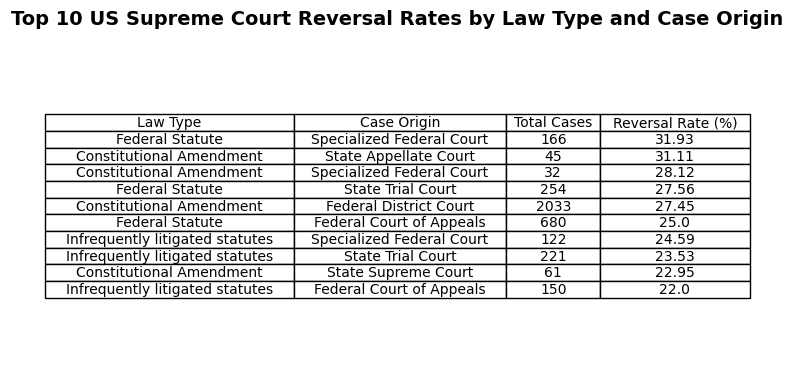

In [21]:
# save the table above as a jpeg
# rename columns for display
top10_display = top10.rename(columns={
    "lawTypeText": "Law Type",
    "caseOriginType": "Case Origin",
    "total_cases": "Total Cases",
    "reversed_cases": "Reversed Cases",
    "reversal_rate": "Reversal Rate (%)"
})

# round reversal rate to 2 decimals (e.g., 0.3122 -> 31.22)
top10_display["Reversal Rate (%)"] = (top10_display["Reversal Rate (%)"] * 100).round(2)

# create figure
fig, ax = plt.subplots(figsize=(10, 4))  # adjust size as needed
ax.axis('off')  # hide axes

# add title
ax.set_title(
    "Top 10 US Supreme Court Reversal Rates by Law Type and Case Origin",
    fontsize=14,
    fontweight='bold',
    pad=20
)

# render table
table = ax.table(
    cellText=top10_display[["Law Type", "Case Origin", "Total Cases", "Reversal Rate (%)"]].values,
    colLabels=["Law Type", "Case Origin", "Total Cases", "Reversal Rate (%)"],
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(top10_display.columns))))

# save as JPEG
plt.savefig("../results/tbl_top10_reversal_rate_by_origin_lawType.jpg", dpi=300, bbox_inches='tight')
plt.show()